In [1]:
! pip install fancyimpute

cvxpy 1.0.6 has requirement numpy>=1.14, but you'll have numpy 1.12.1 which is incompatible.


In [2]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import diagnostic_plots
import datetime


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from copy import deepcopy

%matplotlib inline

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# This cell is just about making things look nice

# Make plots bigger by default.
# Has to occur after the %matplotlib inline in a different cell. Known issue
plt.rc('figure', figsize=(16.0, 10.0))
matplotlib.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

In [18]:
with open('./data/car_specs_2640.pkl', 'rb') as picklefile:
    data = pickle.load(picklefile)

In [19]:
colnames = ['stock_id', 
            'vin_id', 
            'images', 
            'model', 
            'year', 
            'make',
            'city',
            'highway',
            'exterior_color',
            'interior_color',
            'transmission',
            'drive',
            'engine',
            'cylinder',
            'horsepower',
            'torque',
            'rating_5',
            'rating_4',
            'rating_3',
            'rating_2',
            'rating_1',
            'price',
            'mileage',
            'store',
            'accident',
            'owner',
            'problem',
            'odometer',
            'event',
            'recall'
           ]

In [20]:
df = pd.DataFrame(data, columns = colnames)
df.set_index('stock_id', inplace=True)

In [21]:
## Remove the information irrelevant to prediction
reduced_columns = [
            'images', 
            'year', 
            'make',
            'city',
            'highway',
            'transmission',
            'drive',
            'engine',
            'cylinder',
            'horsepower',
            'torque',
            'rating_5',
            'rating_4',
            'rating_3',
            'rating_2',
            'rating_1',
            'price',
            'mileage',
            'store',
            'owner',
            'event',
            'recall'
           ]

In [38]:
reduced_df = df[reduced_columns]
reduced_df.head()

,images,year,make,city,highway,transmission,drive,engine,cylinder,horsepower,...,rating_4,rating_3,rating_2,rating_1,price,mileage,store,owner,event,recall
stock_id,,,,,,,,,,,,,,,,,,,,,
16061803,23,2013,Acura,20,29,Automatic,2WD,3.5,6,280,...,3,1,0,0,18998,42,"San Francisco, CA",2,NOT OK,0
15824438,22,2017,Acura,24,35,Automatic,2WD,2.4,4,206,...,0,0,0,0,24998,20,"San Francisco, CA",1,NOT OK,0
15165784,21,2015,Audi,23,33,Automatic,2WD,1.8,4,170,...,1,0,0,0,17599,36,"San Francisco, CA",1,NOT OK,1
15210066,21,2015,Audi,N/A,N/A,Automatic,2WD,2.0,4,N/A,...,1,0,0,0,16998,37,"San Francisco, CA",1,NOT OK,0
15824549,22,2016,Audi,24,33,Automatic,4WD,2.0,4,220,...,0,0,0,0,24599,12,"San Francisco, CA",1,OK,0


In [39]:
len(reduced_df.store.unique())

21

In [40]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 16061803 to 15438636
Data columns (total 22 columns):
images          2640 non-null int64
year            2640 non-null object
make            2640 non-null object
city            2640 non-null object
highway         2640 non-null object
transmission    2640 non-null object
drive           2640 non-null object
engine          2640 non-null object
cylinder        2640 non-null object
horsepower      2640 non-null object
torque          2640 non-null object
rating_5        2640 non-null int64
rating_4        2640 non-null int64
rating_3        2640 non-null int64
rating_2        2640 non-null int64
rating_1        2640 non-null int64
price           2640 non-null object
mileage         2640 non-null object
store           2640 non-null object
owner           2640 non-null int64
event           2640 non-null object
recall          2640 non-null int64
dtypes: int64(8), object(14)
memory usage: 474.4+ KB


In [41]:
# Drop the samples without price, and convert price to float
reduced_df = reduced_df[reduced_df['price'] != 'N/A']
reduced_df['price'] = reduced_df['price'].astype(float)

In [42]:
reduced_df.shape

(2153, 22)

In [43]:
reduced_df['store'].value_counts()

San Francisco, CA      211
From Pleasanton, CA    204
From Santa Rosa, CA    204
From Roseville, CA     203
From Reno, NV          197
From Fremont, CA       174
San Jose, CA           170
From Fairfield, CA     158
From Sacramento, CA    134
From Modesto, CA       105
From Fresno, CA         90
Fremont, CA             70
Modesto, CA             66
Fresno, CA              46
Sacramento, CA          42
Roseville, CA           42
Pleasanton, CA          20
From San Jose, CA       10
Santa Rosa, CA           5
Fairfield, CA            2
Name: store, dtype: int64

In [27]:
# Convert the years into age
now = datetime.datetime.now()
reduced_df['year'] = now.year - reduced_df['year'].astype(int) +1
reduced_df.rename(columns={'year':'age'}, inplace=True)

In [28]:
reduced_df['make'] = reduced_df['make'].astype(str)
reduced_df['mileage'] = reduced_df['mileage'].astype(float)

In [29]:
reduced_df['store'] = reduced_df['store'].astype(str)
reduced_df['store'] = reduced_df['store'].apply(lambda x:x.replace("From ",""))

In [30]:
reduced_df['event'] = reduced_df['event'].astype(str)
reduced_df.loc[reduced_df['event']=='OK', 'event'] = 1
reduced_df.loc[reduced_df['event']=='NOT OK', 'event'] = 0

In [31]:
reduced_df.head()

,images,age,make,city,highway,transmission,drive,engine,cylinder,horsepower,...,rating_4,rating_3,rating_2,rating_1,price,mileage,store,owner,event,recall
stock_id,,,,,,,,,,,,,,,,,,,,,
16061803,23,6,Acura,20,29,Automatic,2WD,3.5,6,280,...,3,1,0,0,18998.0,42.0,"San Francisco, CA",2,0,0
15824438,22,2,Acura,24,35,Automatic,2WD,2.4,4,206,...,0,0,0,0,24998.0,20.0,"San Francisco, CA",1,0,0
15165784,21,4,Audi,23,33,Automatic,2WD,1.8,4,170,...,1,0,0,0,17599.0,36.0,"San Francisco, CA",1,0,1
15210066,21,4,Audi,N/A,N/A,Automatic,2WD,2.0,4,N/A,...,1,0,0,0,16998.0,37.0,"San Francisco, CA",1,0,0
15824549,22,3,Audi,24,33,Automatic,4WD,2.0,4,220,...,0,0,0,0,24599.0,12.0,"San Francisco, CA",1,1,0


In [32]:
reduced_df['transmission'] = reduced_df['transmission'].astype(str)
reduced_df.loc[reduced_df['transmission'] == 'Automatic', 'transmission'] = 0
reduced_df.loc[reduced_df['transmission'] == 'Manual', 'transmission'] = 1

In [33]:
reduced_df['drive'] = reduced_df['drive'].astype(str)
reduced_df.loc[reduced_df['drive'] == '2WD', 'drive'] = 0
reduced_df.loc[reduced_df['drive'] == '4WD', 'drive'] = 1
reduced_df['drive'] = reduced_df['drive'].astype(int)

In [34]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 16061803 to 15438636
Data columns (total 22 columns):
images          2153 non-null int64
age             2153 non-null int64
make            2153 non-null object
city            2153 non-null object
highway         2153 non-null object
transmission    2153 non-null int64
drive           2153 non-null int64
engine          2153 non-null object
cylinder        2153 non-null object
horsepower      2153 non-null object
torque          2153 non-null object
rating_5        2153 non-null int64
rating_4        2153 non-null int64
rating_3        2153 non-null int64
rating_2        2153 non-null int64
rating_1        2153 non-null int64
price           2153 non-null float64
mileage         2153 non-null float64
store           2153 non-null object
owner           2153 non-null int64
event           2153 non-null int64
recall          2153 non-null int64
dtypes: float64(2), int64(12), object(8)
memory usage: 386.9+ KB


In [45]:
reduced_df.make.value_counts()

Ford             297
Nissan           182
BMW              151
Hyundai          146
Chevrolet        137
Honda            134
Dodge            110
Volkswagen       109
Toyota            98
Jeep              91
Mercedes-Benz     90
Kia               63
Mazda             61
Lexus             56
Infiniti          51
Audi              44
Subaru            41
Chrysler          34
Mini              33
Buick             32
Acura             32
GMC               27
Land              22
Fiat              20
Jaguar            18
Cadillac          16
Lincoln           13
Porsche           11
Volvo              8
Mitsubishi         7
Scion              7
Smart              6
Mercury            5
Pontiac            1
Name: make, dtype: int64

In [37]:
reduced_df.store.unique()

array(['San Francisco, CA', 'Fremont, CA', 'San Jose, CA',
       'Pleasanton, CA', 'Fairfield, CA', 'Santa Rosa, CA',
       'Sacramento, CA', 'Roseville, CA', 'Modesto, CA', 'Fresno, CA',
       'Reno, NV'], dtype=object)

In [36]:
reduced_df.shape

(2153, 22)

### Analyze the make clusters

In [45]:
reduced_df.head()

,images,age,make,city,highway,transmission,drive,engine,cylinder,horsepower,...,rating_4,rating_3,rating_2,rating_1,price,mileage,store,owner,event,recall
stock_id,,,,,,,,,,,,,,,,,,,,,
16061803,23,6,Acura,20,29,0,0,3.5,6,280,...,3,1,0,0,18998.0,42.0,"San Francisco, CA",2,0,0
15824438,22,2,Acura,24,35,0,0,2.4,4,206,...,0,0,0,0,24998.0,20.0,"San Francisco, CA",1,0,0
15165784,21,4,Audi,23,33,0,0,1.8,4,170,...,1,0,0,0,17599.0,36.0,"San Francisco, CA",1,0,1
15210066,21,4,Audi,N/A,N/A,0,0,2.0,4,N/A,...,1,0,0,0,16998.0,37.0,"San Francisco, CA",1,0,0
15824549,22,3,Audi,24,33,0,1,2.0,4,220,...,0,0,0,0,24599.0,12.0,"San Francisco, CA",1,1,0


In [64]:
(reduced_df.groupby('make').mean()).sort_values(by=['price'])['price']

make
Smart             8598.166667
Pontiac           8998.000000
Mercury          10838.400000
Volkswagen       14108.458716
Mitsubishi       14226.714286
Hyundai          15066.835616
Fiat             15568.200000
Scion            15741.142857
Mini             16028.454545
Nissan           16043.313187
Chrysler         16139.411765
Kia              16328.365079
Toyota           17532.989796
Mazda            17932.672131
Ford             18046.053872
Buick            18323.125000
Volvo            18898.250000
Honda            19392.164179
Chevrolet        19579.175182
Jeep             20888.274725
Acura            22054.343750
Subaru           22773.682927
Lincoln          24351.923077
Dodge            24623.572727
BMW              25051.079470
Infiniti         25445.117647
Mercedes-Benz    25729.144444
Lexus            27233.839286
Audi             28334.431818
GMC              29331.333333
Cadillac         29723.062500
Jaguar           33442.444444
Land             37043.454545
Porsc

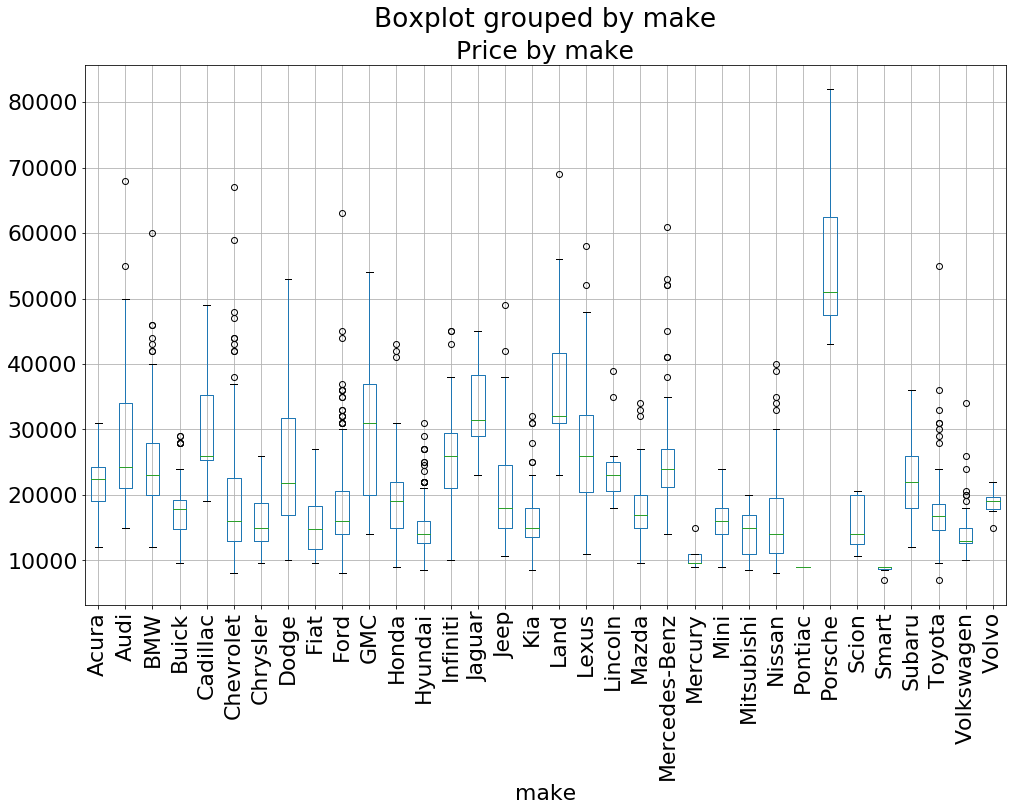

In [47]:
reduced_df.boxplot(column='price', by='make', rot=90)
#plt.xticks(rotation=90)
plt.title('Price by make', fontsize=25)
plt.savefig('make-price-boxplot.png')

In [89]:
reduced_df.make.unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Chevrolet', 'Chrysler', 'Dodge',
       'Ford', 'GMC', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar', 'Jeep',
       'Kia', 'Land', 'Lexus', 'Lincoln', 'Mazda', 'Mercedes-Benz', 'Mini',
       'Nissan', 'Porsche', 'Smart', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo', 'Fiat', 'Mitsubishi', 'Scion', 'Cadillac', 'Mercury',
       'Pontiac'], dtype=object)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]), <a list of 20 Text xticklabel objects>)

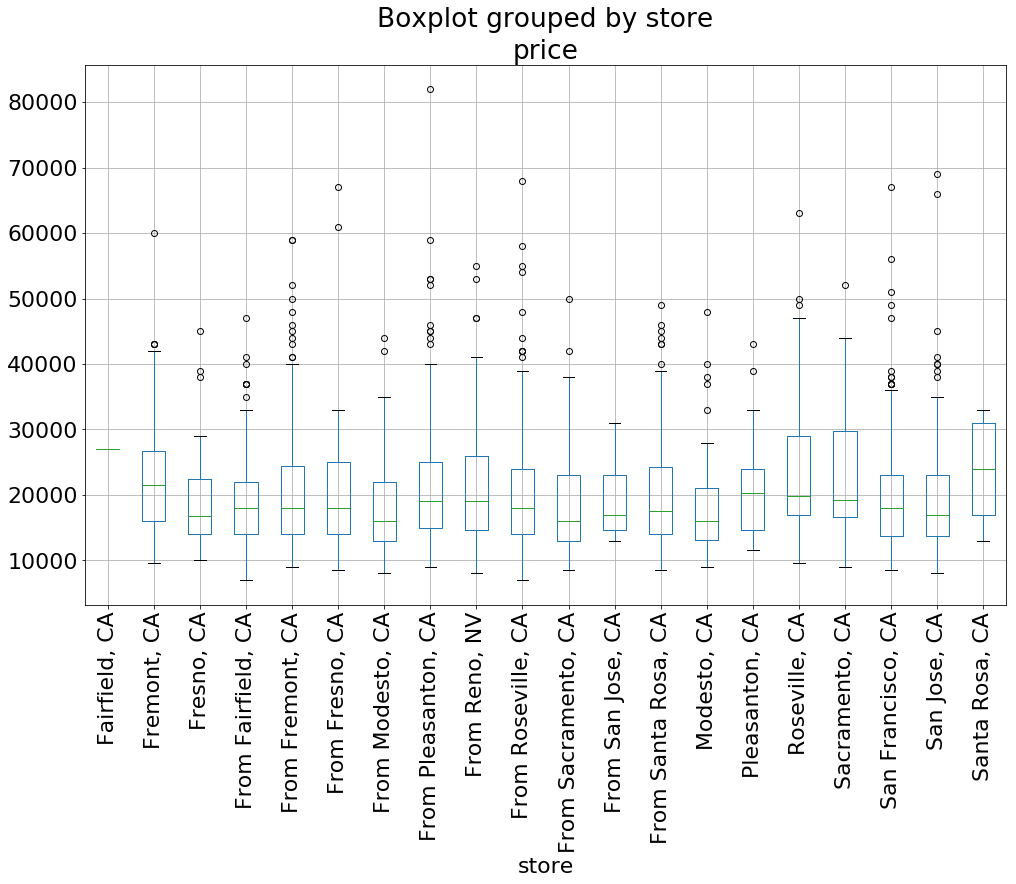

In [16]:
reduced_df.boxplot(column='price', by='store')
plt.xticks(rotation=90)

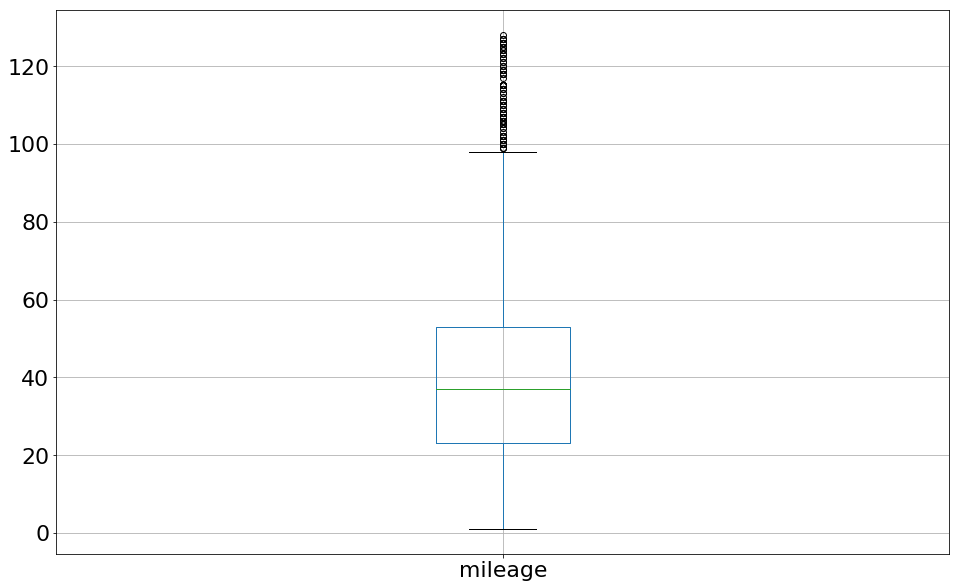

In [80]:
reduced_df.boxplot(column='mileage')

In [65]:
luxury_cars = (['Lincoln', 'Dodge', 'BMW', 'Infiniti', 'Mercedes-Benz', 'Lexus', 'Audi' ,'GMC', 'Cadillac', 'Jaguar', 
               'Land', 'Porsche'])

In [69]:
reduced_df_luxury = reduced_df

In [73]:
reduced_df_luxury['luxury'] = reduced_df_luxury['make'].apply(lambda x:1 if x in luxury_cars else 0) 

In [77]:
with open('reduced_df_luxury.pkl', 'wb') as picklefile:
    pickle.dump(reduced_df_luxury, picklefile)

## Dummify the categorical values

In [19]:
X = patsy.dmatrix('store', data=reduced_df, return_type='dataframe')
X.drop('Intercept', axis = 1, inplace=True)

In [20]:
reduced_df2 = reduced_df.join(X)

In [22]:
X = patsy.dmatrix('make', data=reduced_df, return_type='dataframe', )

In [23]:
reduced_df2 = reduced_df2.join(X)
reduced_df2.drop('make', axis=1, inplace=True)
reduced_df2.drop('store', axis=1, inplace=True)

In [24]:
reduced_df2.columns

Index(['images', 'age', 'city', 'highway', 'transmission', 'drive', 'engine',
       'cylinder', 'horsepower', 'torque', 'rating_5', 'rating_4', 'rating_3',
       'rating_2', 'rating_1', 'price', 'mileage', 'owner', 'event', 'recall',
       'store[T.Fremont, CA]', 'store[T.Fresno, CA]', 'store[T.Modesto, CA]',
       'store[T.Pleasanton, CA]', 'store[T.Reno, NV]',
       'store[T.Roseville, CA]', 'store[T.Sacramento, CA]',
       'store[T.San Francisco, CA]', 'store[T.San Jose, CA]',
       'store[T.Santa Rosa, CA]', 'Intercept', 'make[T.Audi]', 'make[T.BMW]',
       'make[T.Buick]', 'make[T.Cadillac]', 'make[T.Chevrolet]',
       'make[T.Chrysler]', 'make[T.Dodge]', 'make[T.Fiat]', 'make[T.Ford]',
       'make[T.GMC]', 'make[T.Honda]', 'make[T.Hyundai]', 'make[T.Infiniti]',
       'make[T.Jaguar]', 'make[T.Jeep]', 'make[T.Kia]', 'make[T.Land]',
       'make[T.Lexus]', 'make[T.Lincoln]', 'make[T.Mazda]',
       'make[T.Mercedes-Benz]', 'make[T.Mercury]', 'make[T.Mini]',
       'make[

In [25]:
reduced_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2153 entries, 16061803 to 15438636
Data columns (total 64 columns):
images                        2153 non-null int64
age                           2153 non-null int64
city                          2153 non-null object
highway                       2153 non-null object
transmission                  2153 non-null int64
drive                         2153 non-null int64
engine                        2153 non-null object
cylinder                      2153 non-null object
horsepower                    2153 non-null object
torque                        2153 non-null object
rating_5                      2153 non-null int64
rating_4                      2153 non-null int64
rating_3                      2153 non-null int64
rating_2                      2153 non-null int64
rating_1                      2153 non-null int64
price                         2153 non-null float64
mileage                       2153 non-null float64
owner                      

In [26]:
with open('./data/processed/reduced_df2.pkl', 'wb') as picklefile:
    pickle.dump(reduced_df2, picklefile)

## Train Test Split

In [67]:
y = reduced_df2['price']
X = reduced_df2.drop(('price'), axis = 1, inplace = False)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Analyze the missing values

In [925]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 16111008 to 16058590
Data columns (total 60 columns):
images                        1340 non-null int64
age                           1340 non-null int64
city                          1340 non-null object
highway                       1340 non-null object
transmission                  1340 non-null int64
drive                         1340 non-null int64
engine                        1340 non-null object
cylinder                      1340 non-null object
horsepower                    1340 non-null object
torque                        1340 non-null object
rating_5                      1340 non-null int64
rating_4                      1340 non-null int64
rating_3                      1340 non-null int64
rating_2                      1340 non-null int64
rating_1                      1340 non-null int64
mileage                       1340 non-null float64
owner                         1340 non-null int64
event                        

In [926]:
for col in X_train.columns:
    print (col, "\n", X_train[col].value_counts())

images 
 21    282
20    270
23    199
22    193
19    121
0     102
24     79
18     43
25     24
26     17
27      7
29      2
28      1
Name: images, dtype: int64
age 
 4     413
3     211
5     166
2     163
6     151
7      76
8      43
9      41
11     25
1      21
12     16
10     14
Name: age, dtype: int64
city 
 22     130
N/A    112
21      98
25      95
23      90
18      78
17      77
19      74
24      65
27      61
26      58
20      57
28      55
16      52
15      40
14      24
30      21
40      19
29      18
31      17
12      15
43      14
13      12
51       7
126      7
85       7
44       6
41       4
33       4
53       4
42       3
34       3
35       3
32       2
36       2
37       1
106      1
110      1
55       1
128      1
54       1
Name: city, dtype: int64
highway 
 N/A    112
34      91
36      89
31      80
30      80
28      75
25      63
37      62
35      60
33      58
27      53
29      52
38      51
32      51
24      45
26      43
39      40
23  

In [927]:
def imput_training_avg(df, col, navalues):
    non_na = df
    
    for navalue in navalues:
        non_na = non_na.loc[non_na[col]!= navalue]
    
    cal_mean = np.mean(non_na[col].astype(float))
    
    for navalue in navalues:
        df.loc[df[col] == navalue, col] = cal_mean

    return df[col].astype(float), cal_mean

In [928]:
col_to_clean = ['city', 'highway', 'engine', 'cylinder', 'horsepower', 'torque']

training_mean_dict = {}
for col in col_to_clean:
    X_train[col], cal_mean = imput_training_avg(X_train, col, ['N/A', 0])
    training_mean_dict[col] = cal_mean

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [929]:
def impute_training_avg(df, training_mean_dict, navalues):
    for col in training_mean_dict.keys():
        for navalue in navalues:
            df.loc[df[col] == navalue, col] = training_mean_dict[col]
        
        df[col] = df[col].astype(float)
    return df

In [930]:
X_test = impute_training_avg(X_test, training_mean_dict, ['N/A', 0])

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [931]:
X_test.describe()

,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,torque,...,make[T.Mini],make[T.Mitsubishi],make[T.Nissan],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
count,447.00000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,...,447.000000,447.000000,447.000000,447.000000,447.0,447.000000,447.000000,447.000000,447.000000,447.000000
mean,19.39821,4.474273,24.208398,31.879586,0.046980,0.172260,2.667696,4.886700,219.519749,218.611849,...,0.013423,0.004474,0.089485,0.006711,0.0,0.002237,0.017897,0.044743,0.055928,0.004474
std,6.21605,2.018665,12.518129,9.338549,0.211833,0.378029,1.110350,1.277892,85.166968,88.849218,...,0.115206,0.066815,0.285763,0.081739,0.0,0.047298,0.132726,0.206970,0.230041,0.066815
min,0.00000,1.000000,12.000000,17.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.00000,3.000000,19.000000,27.000000,0.000000,0.000000,2.000000,4.000000,170.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.00000,4.000000,22.000000,31.000000,0.000000,0.000000,2.400000,4.000000,199.000000,187.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22.00000,5.000000,25.000000,36.000000,0.000000,0.000000,3.500000,6.000000,283.000000,265.500000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,28.00000,12.000000,128.000000,109.000000,1.000000,1.000000,6.400000,8.000000,556.000000,551.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [932]:
## Turn the categorical values into dummy

In [933]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 16111008 to 16058590
Data columns (total 60 columns):
images                        1340 non-null int64
age                           1340 non-null int64
city                          1340 non-null float64
highway                       1340 non-null float64
transmission                  1340 non-null int64
drive                         1340 non-null int64
engine                        1340 non-null float64
cylinder                      1340 non-null float64
horsepower                    1340 non-null float64
torque                        1340 non-null float64
rating_5                      1340 non-null int64
rating_4                      1340 non-null int64
rating_3                      1340 non-null int64
rating_2                      1340 non-null int64
rating_1                      1340 non-null int64
mileage                       1340 non-null float64
owner                         1340 non-null int64
event                  

In [934]:
#num_cols = ['images', 
            'age', 
            'city',
            'highway',
            'engine',
            'cylinder',
            'horsepower',
            'torque',
            'rating_5',
            'rating_4',
            'rating_3',
            'rating_2',
            'rating_1',
            'mileage',
            'owner',
            'recall']

IndentationError: unexpected indent (<ipython-input-934-a138a547eeaa>, line 2)

In [936]:
X_train_num = deepcopy(X_train)
X_test_num = deepcopy(X_test)

In [937]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 16111008 to 16058590
Data columns (total 60 columns):
images                        1340 non-null int64
age                           1340 non-null int64
city                          1340 non-null float64
highway                       1340 non-null float64
transmission                  1340 non-null int64
drive                         1340 non-null int64
engine                        1340 non-null float64
cylinder                      1340 non-null float64
horsepower                    1340 non-null float64
torque                        1340 non-null float64
rating_5                      1340 non-null int64
rating_4                      1340 non-null int64
rating_3                      1340 non-null int64
rating_2                      1340 non-null int64
rating_1                      1340 non-null int64
mileage                       1340 non-null float64
owner                         1340 non-null int64
event                  

## Fit the data into models

In [938]:
df_num_train = pd.concat((y_train, X_train_num), axis=1)

In [939]:
df_num_train.corr()

,price,images,age,city,highway,transmission,drive,engine,cylinder,horsepower,...,make[T.Mini],make[T.Mitsubishi],make[T.Nissan],make[T.Porsche],make[T.Scion],make[T.Smart],make[T.Subaru],make[T.Toyota],make[T.Volkswagen],make[T.Volvo]
price,1.000000,0.048232,-0.340565,-0.266308,-0.351221,-0.018068,0.442514,0.531417,0.542320,0.668556,...,-0.054313,-0.043577,-0.135264,0.255622,-0.012619,-0.060971,0.046997,-0.080148,-0.165039,-0.008724
images,0.048232,1.000000,-0.005774,0.007958,0.006375,-0.009394,-0.012996,0.051693,0.068227,0.075585,...,-0.053103,-0.036468,-0.023543,-0.063018,0.004860,-0.008473,-0.009871,-0.000463,-0.049977,0.016350
age,-0.340565,-0.005774,1.000000,-0.078134,-0.128277,-0.043340,-0.003567,0.131748,0.185377,-0.027547,...,0.040002,-0.023536,0.021969,0.005869,-0.003545,0.000538,-0.051297,0.111565,0.060755,0.005869
city,-0.266308,0.007958,-0.078134,1.000000,0.939734,-0.018085,-0.217609,-0.538606,-0.332160,-0.473927,...,0.016904,0.014397,0.151111,-0.038437,-0.002823,0.040789,-0.003508,0.128922,-0.018822,-0.004341
highway,-0.351221,0.006375,-0.128277,0.939734,1.000000,-0.002529,-0.329724,-0.640258,-0.458629,-0.557579,...,0.026911,0.005711,0.117573,-0.058043,0.001516,0.032396,-0.012804,0.096345,0.001685,0.006438
transmission,-0.018068,-0.009394,-0.043340,-0.018085,-0.002529,1.000000,-0.052009,-0.064976,-0.067485,-0.039112,...,0.044228,-0.014690,-0.012490,-0.016098,0.047139,-0.011370,0.124240,-0.051514,-0.008281,0.033152
drive,0.442514,-0.012996,-0.003567,-0.217609,-0.329724,-0.052009,1.000000,0.311988,0.291255,0.326521,...,-0.021688,-0.030171,-0.038932,0.107854,-0.026975,-0.023353,0.217645,-0.087459,-0.102554,-0.033063
engine,0.531417,0.051693,0.131748,-0.538606,-0.640258,-0.064976,0.311988,1.000000,0.874546,0.776858,...,-0.120889,-0.036061,-0.038525,0.049093,-0.026217,-0.069637,-0.045092,-0.055970,-0.098164,-0.017857
cylinder,0.542320,0.068227,0.185377,-0.332160,-0.458629,-0.067485,0.291255,0.874546,1.000000,0.738849,...,-0.116162,-0.052963,0.028702,0.074681,-0.038805,-0.070597,-0.091625,-0.101052,-0.078720,-0.012635
horsepower,0.668556,0.075585,-0.027547,-0.473927,-0.557579,-0.039112,0.326521,0.776858,0.738849,1.000000,...,-0.099817,-0.057581,-0.070646,0.143803,-0.016715,-0.085457,-0.036688,-0.144427,-0.227210,0.012210


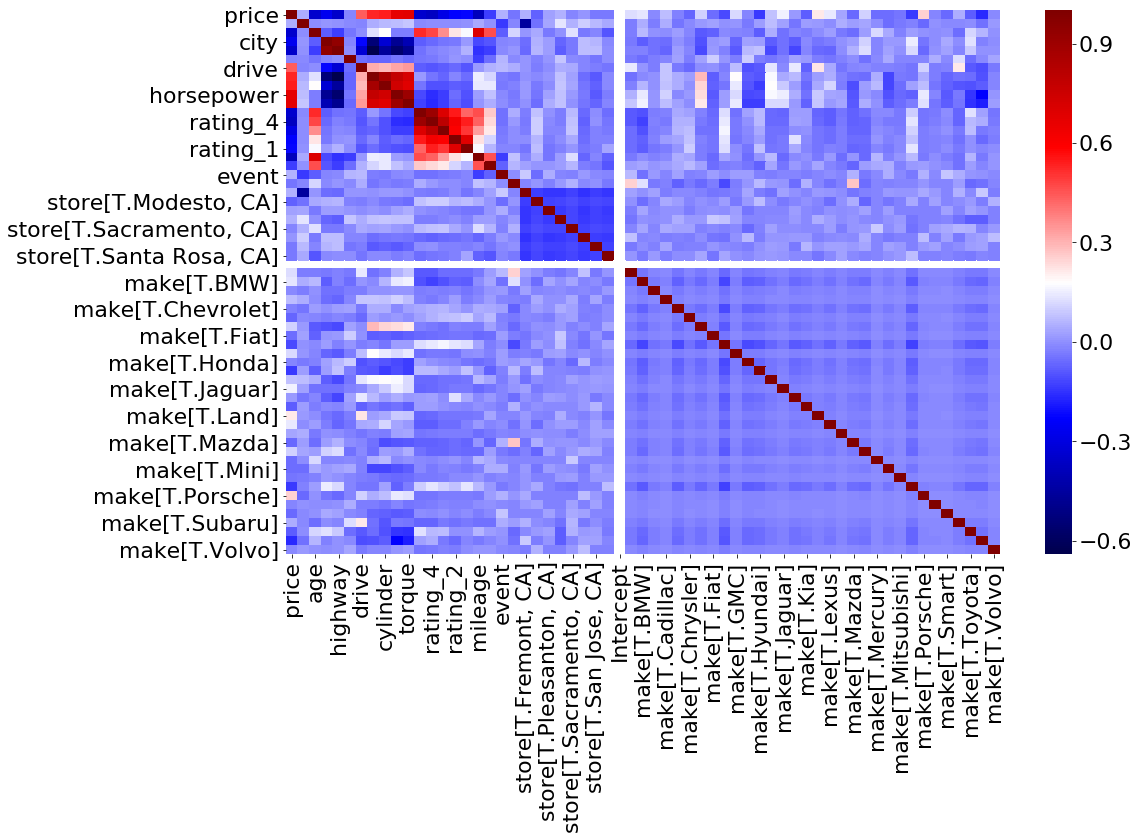

In [940]:
sns.heatmap(df_num_train.corr(), cmap="seismic");

In [813]:
df_num_train_log = pd.concat((np.log(y_train), X_train_num), axis=1)

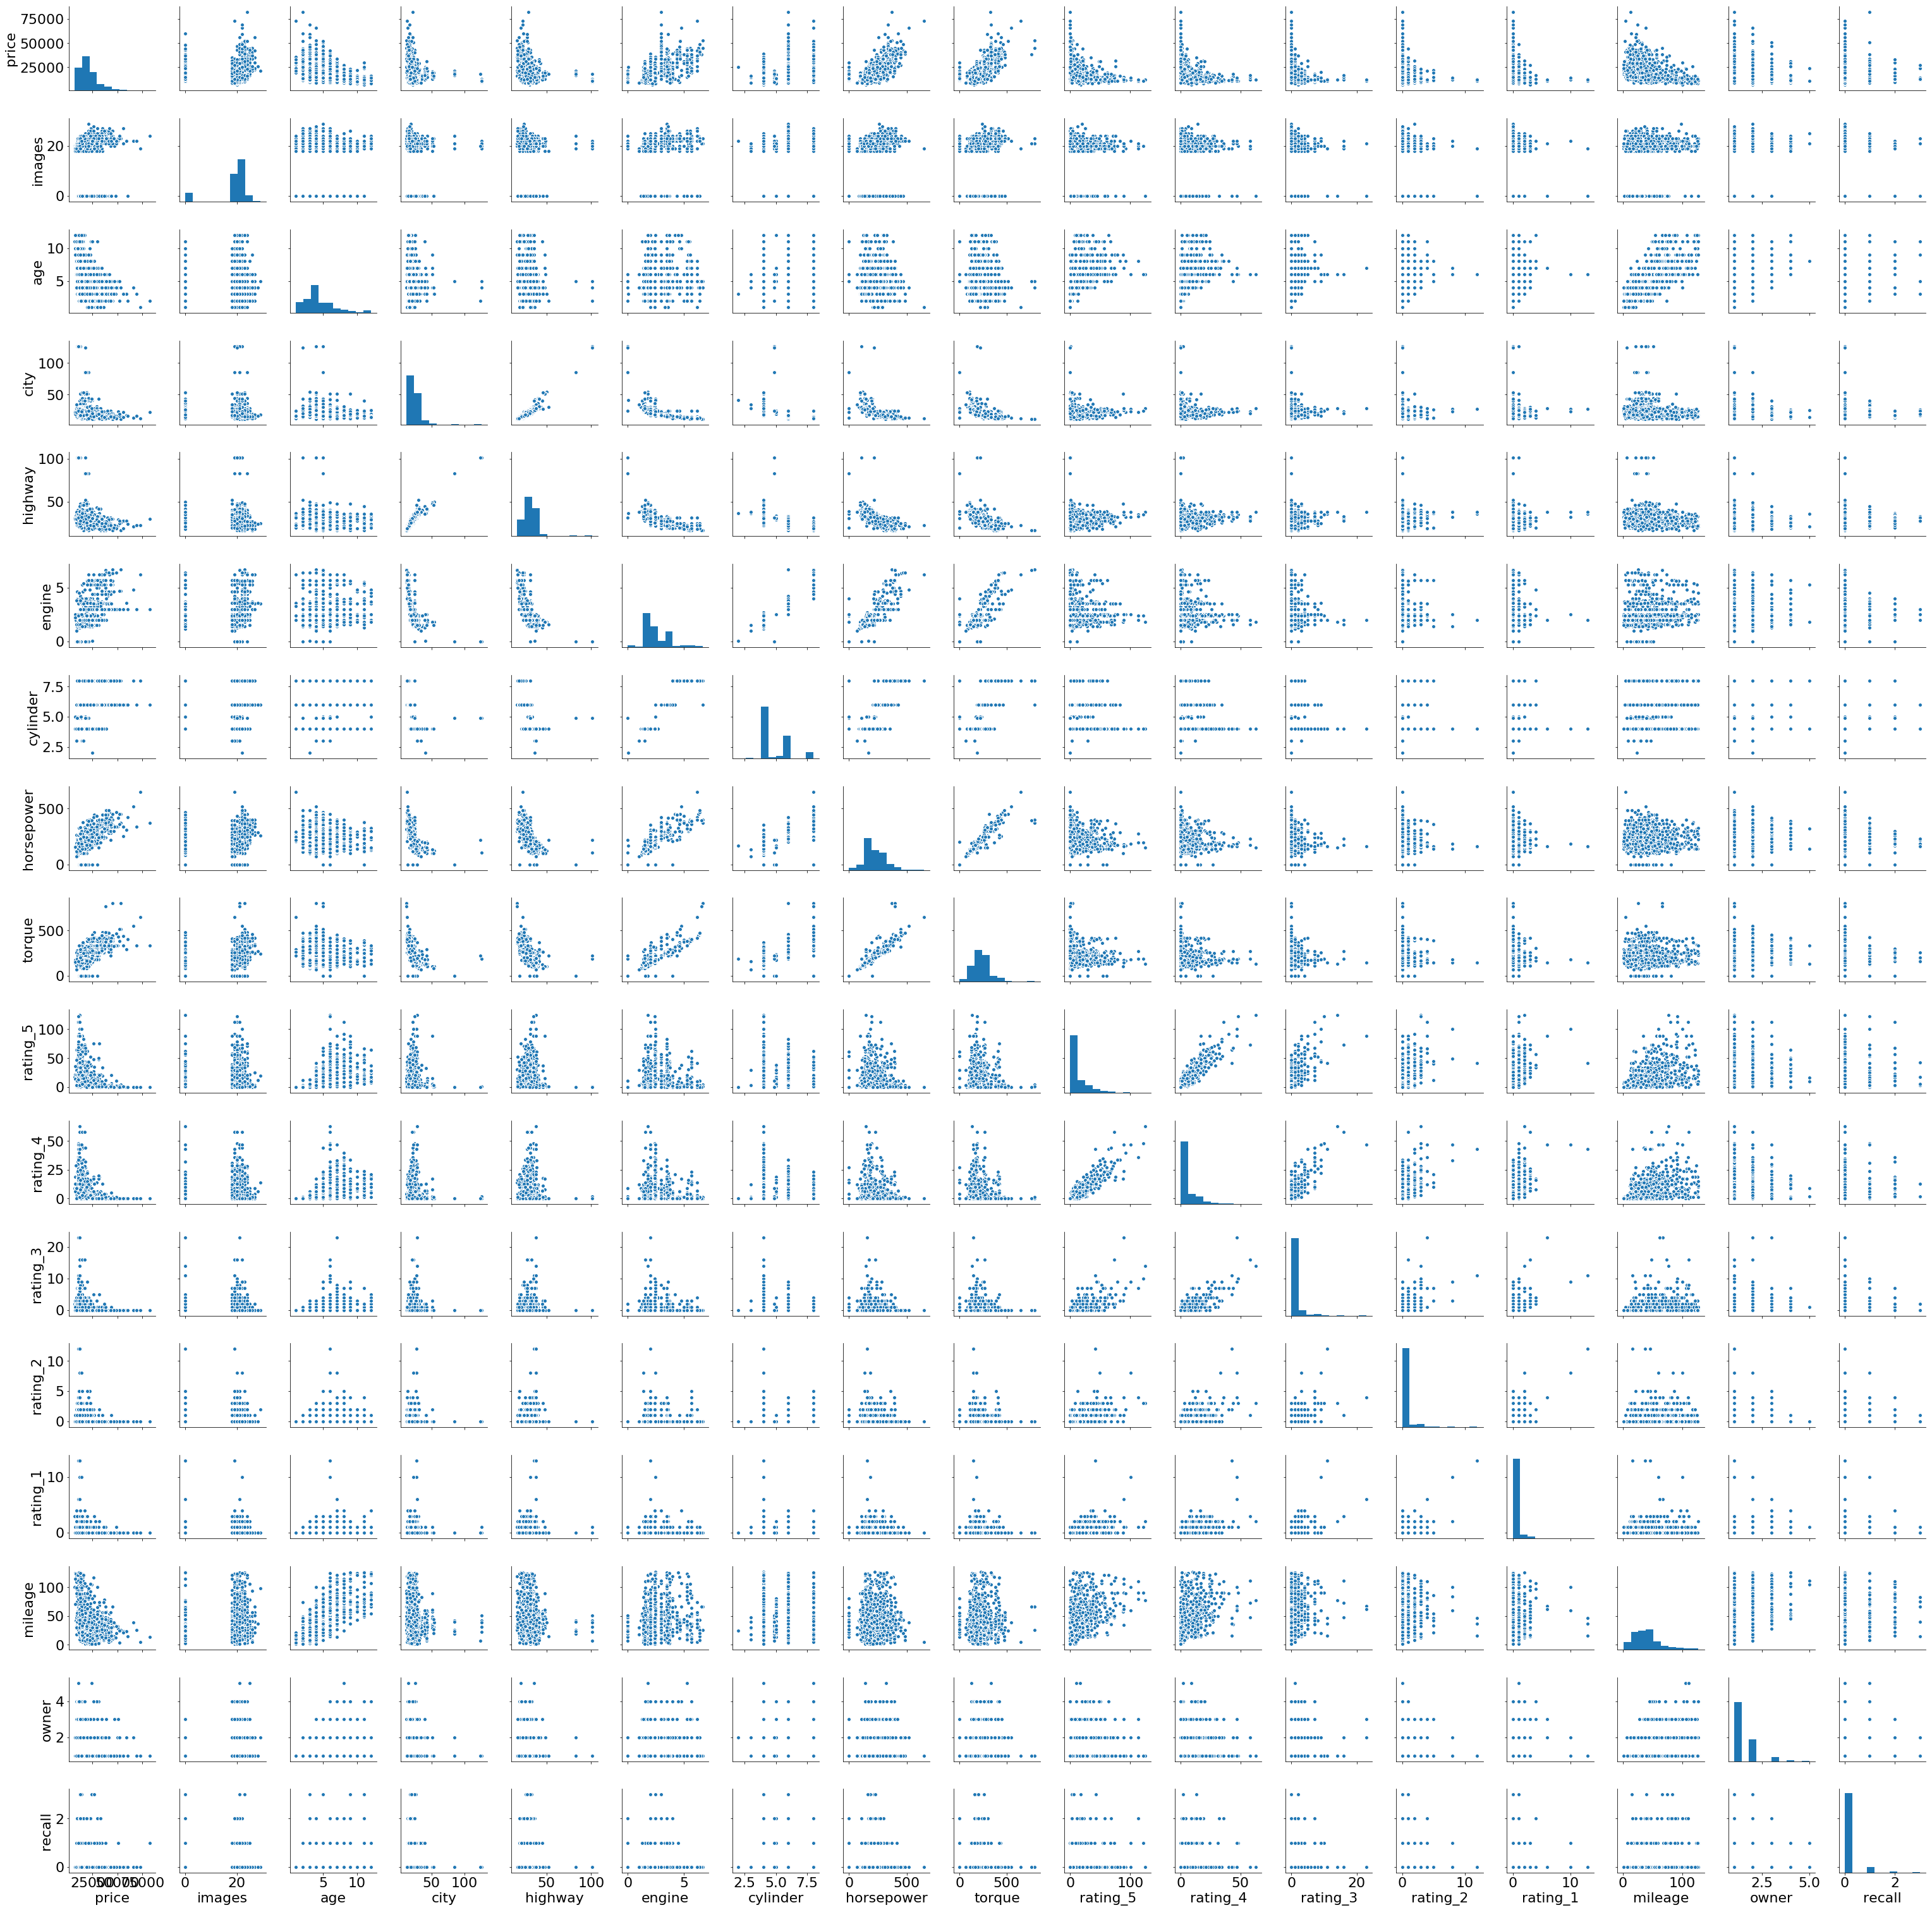

In [396]:
pp = sns.pairplot(data=df_num_train)

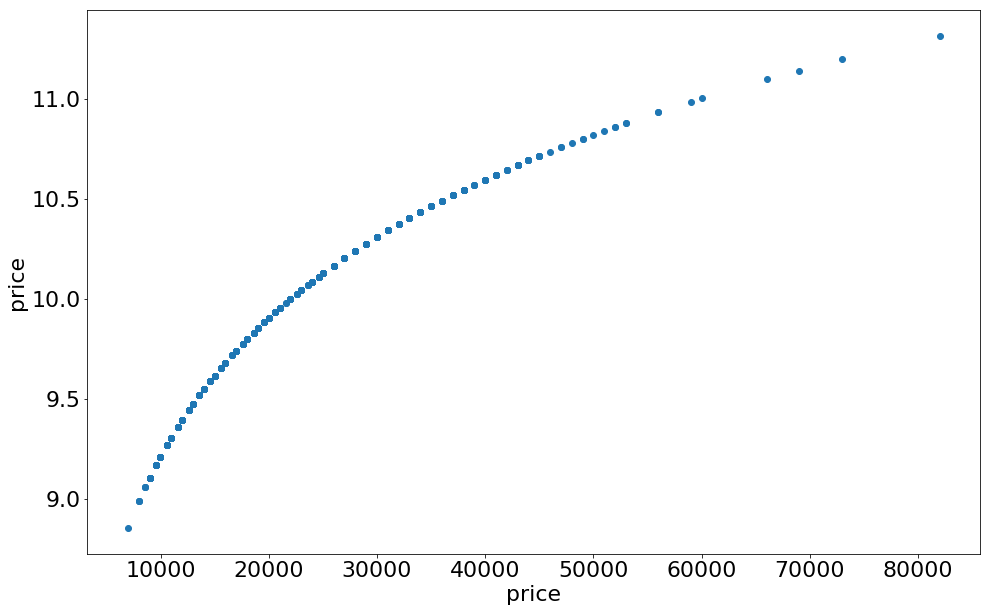

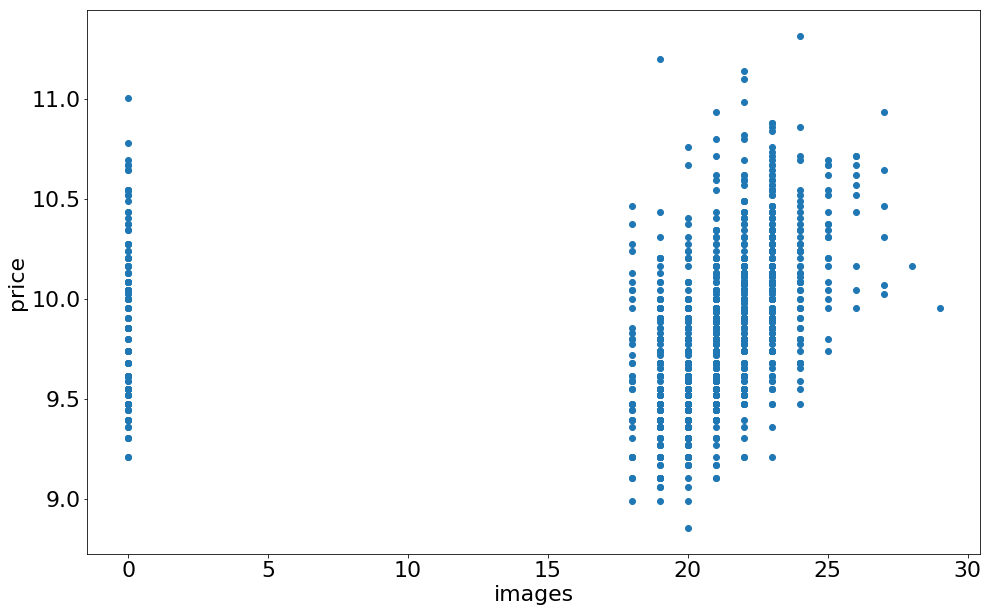

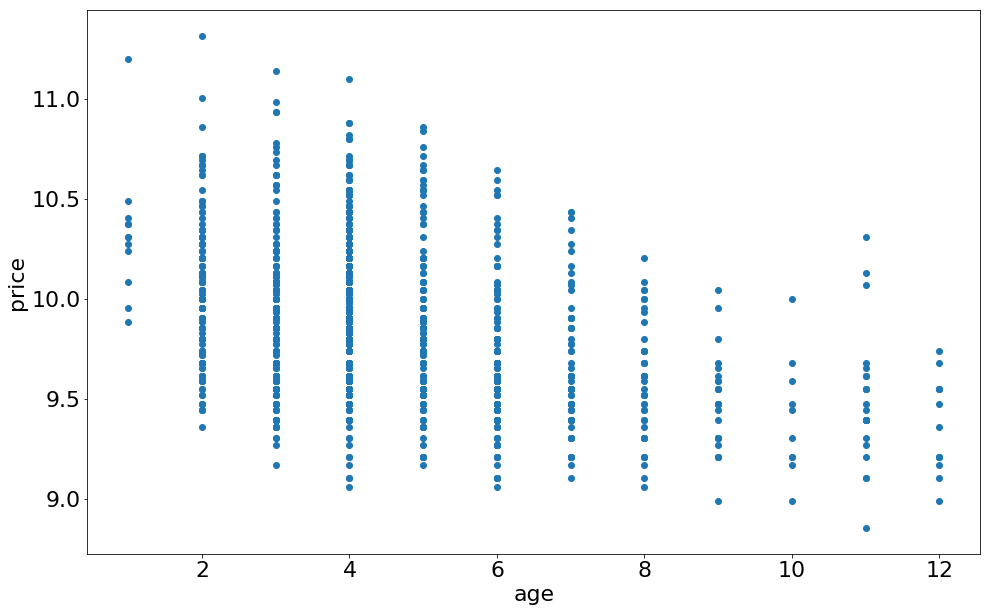

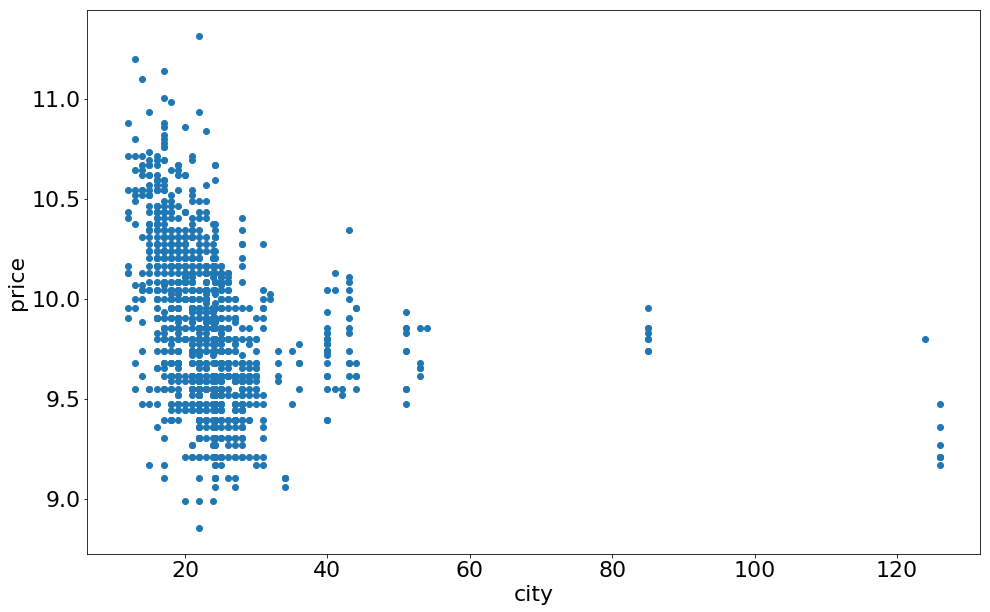

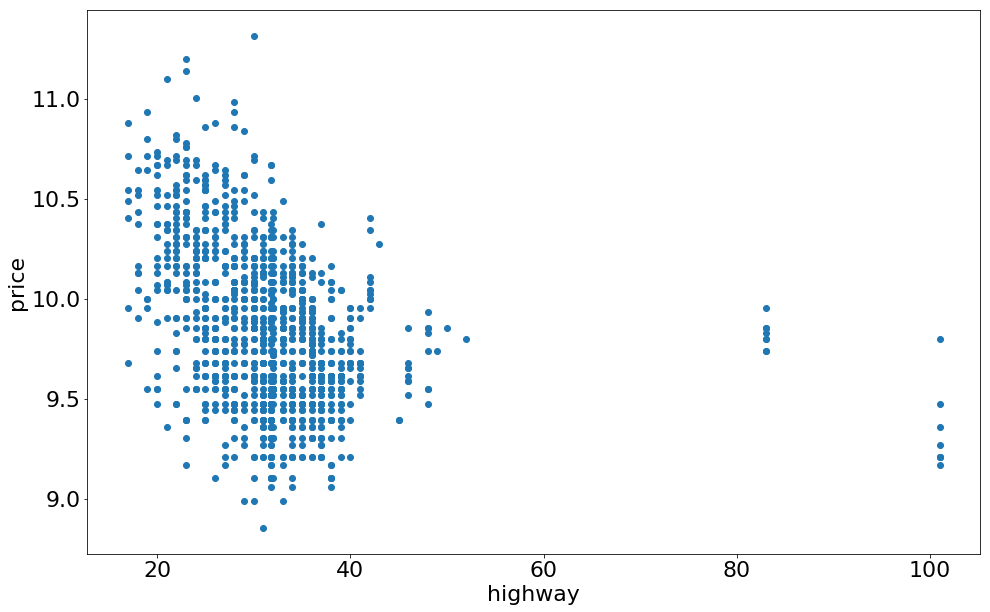

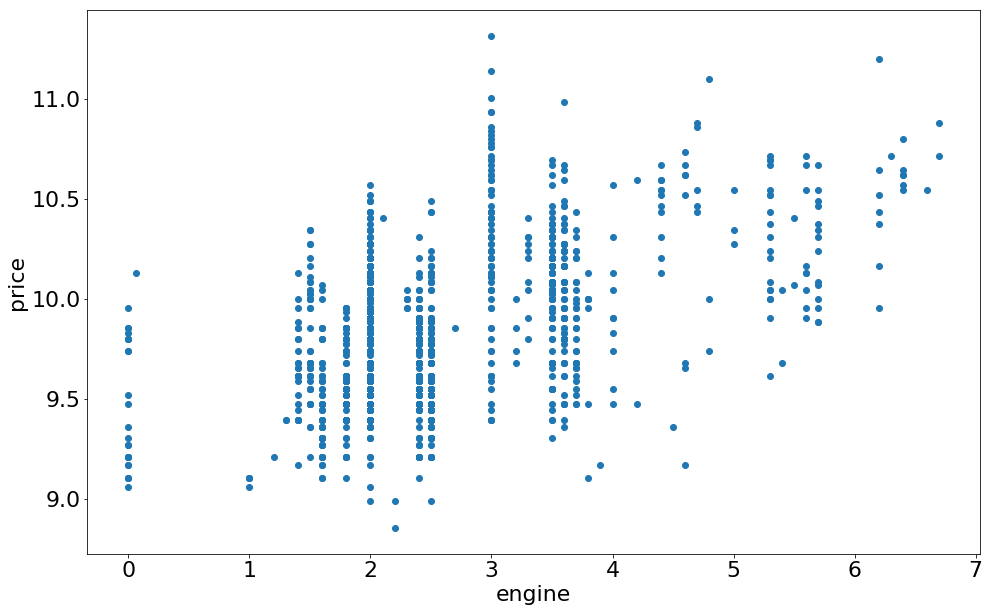

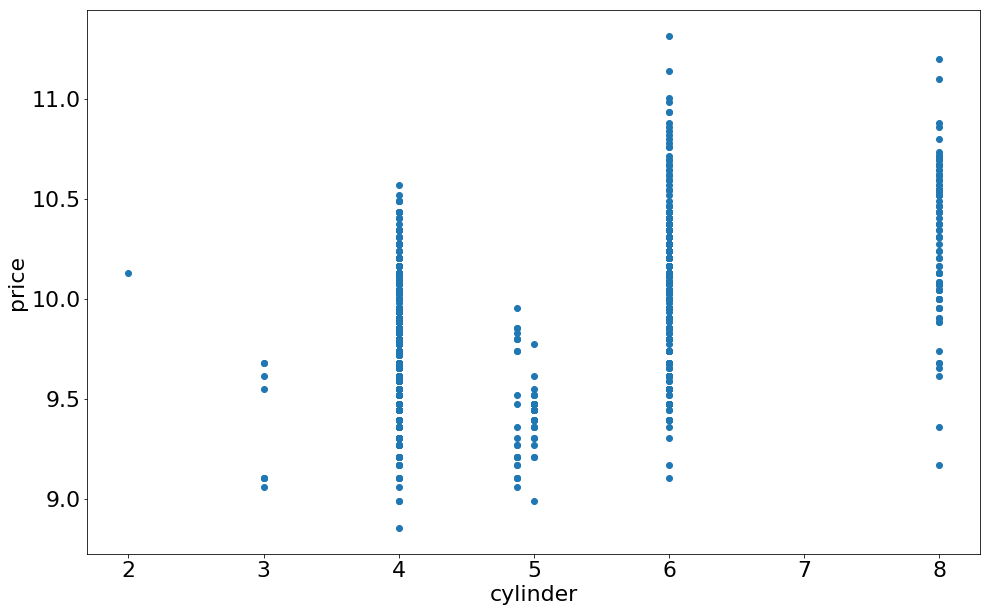

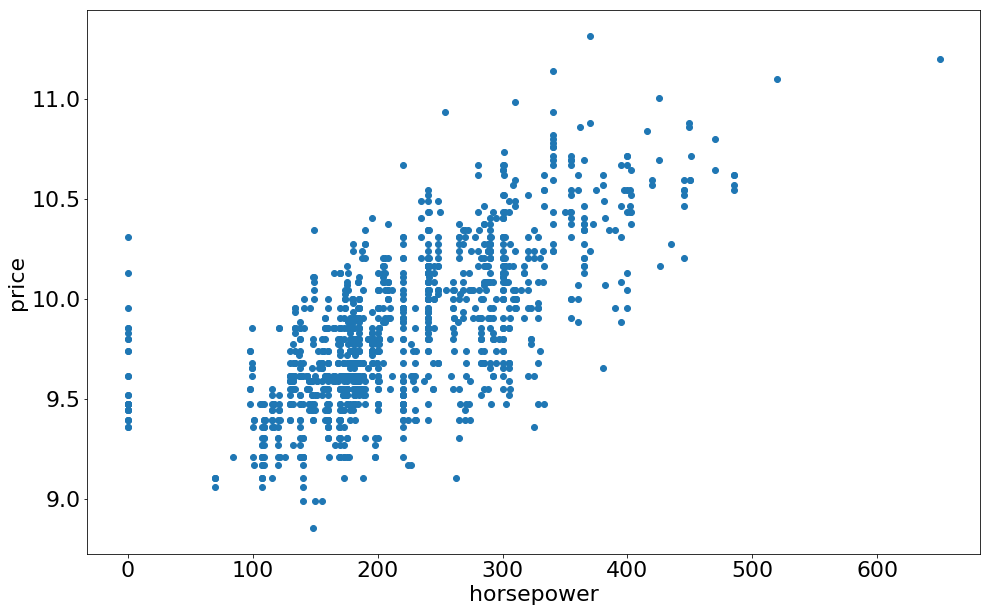

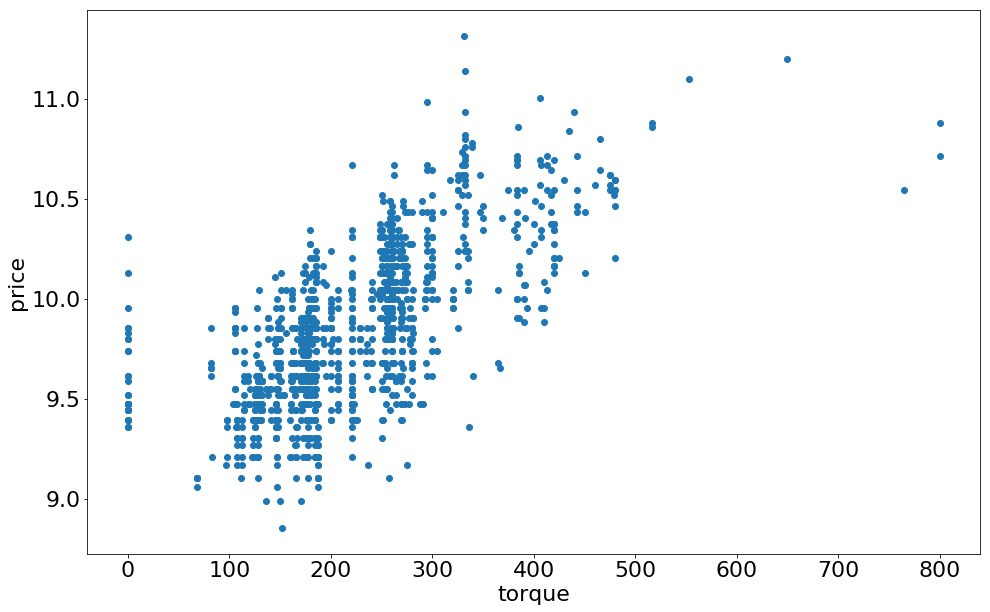

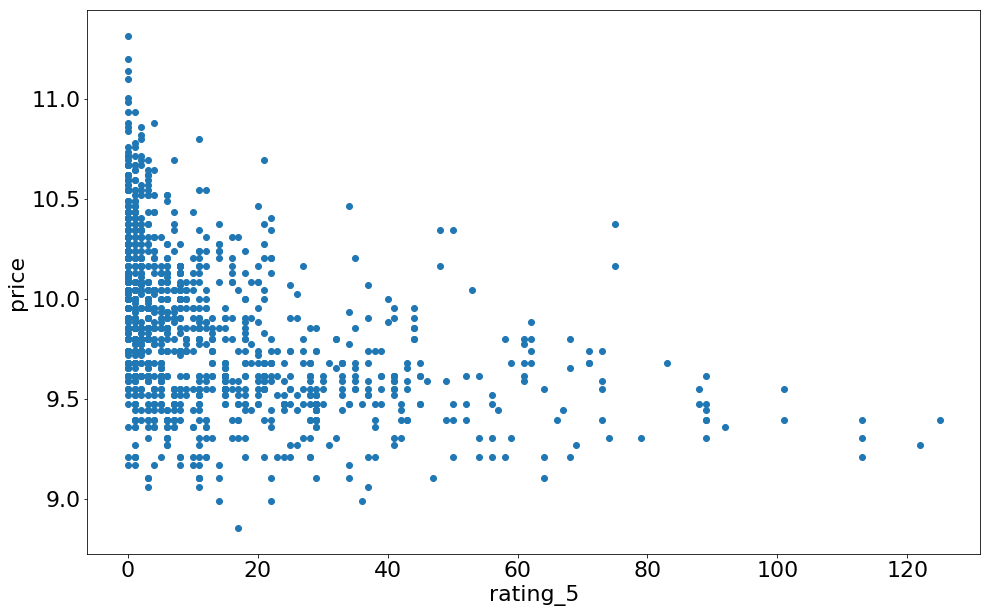

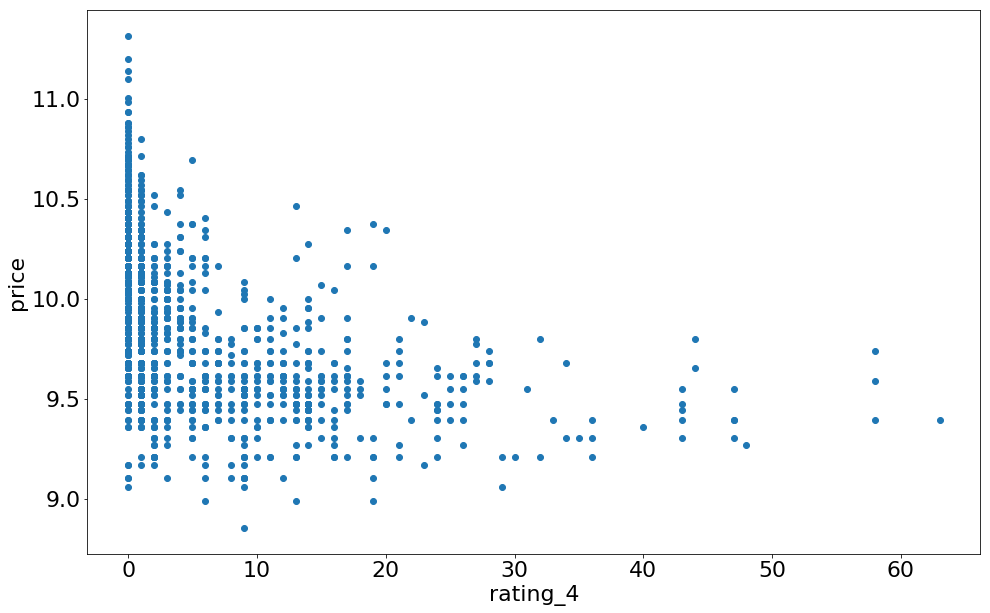

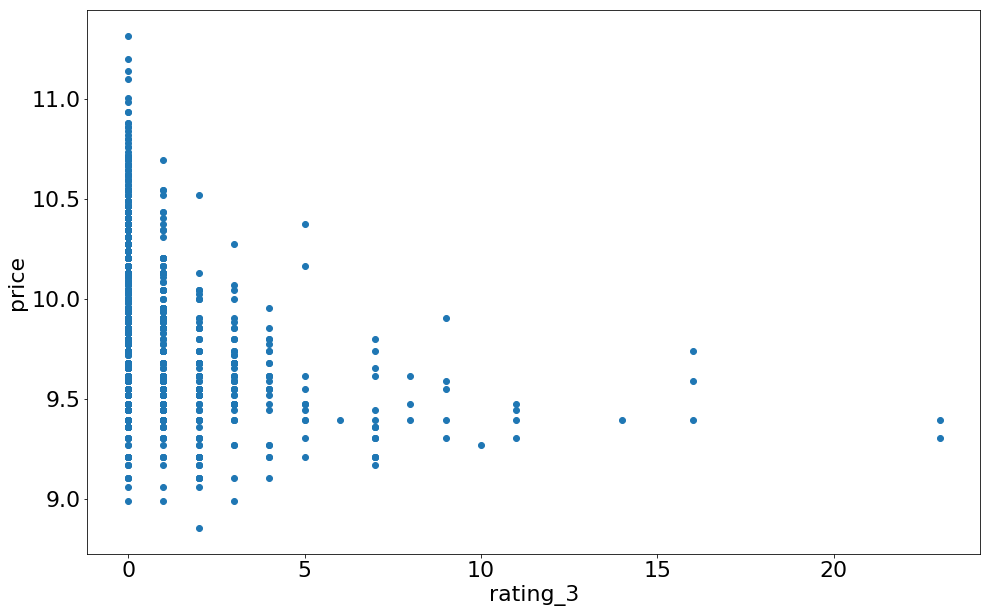

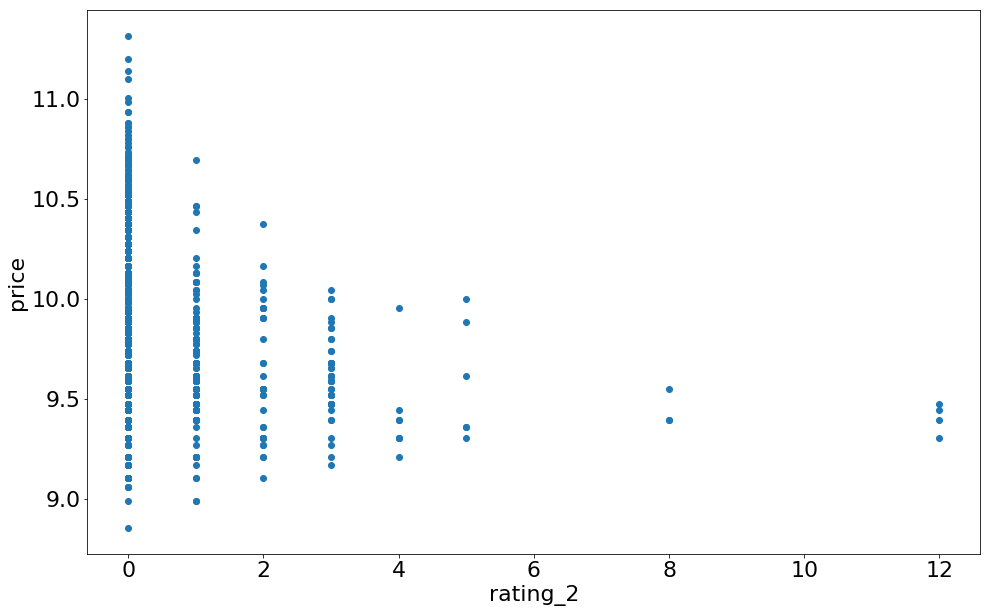

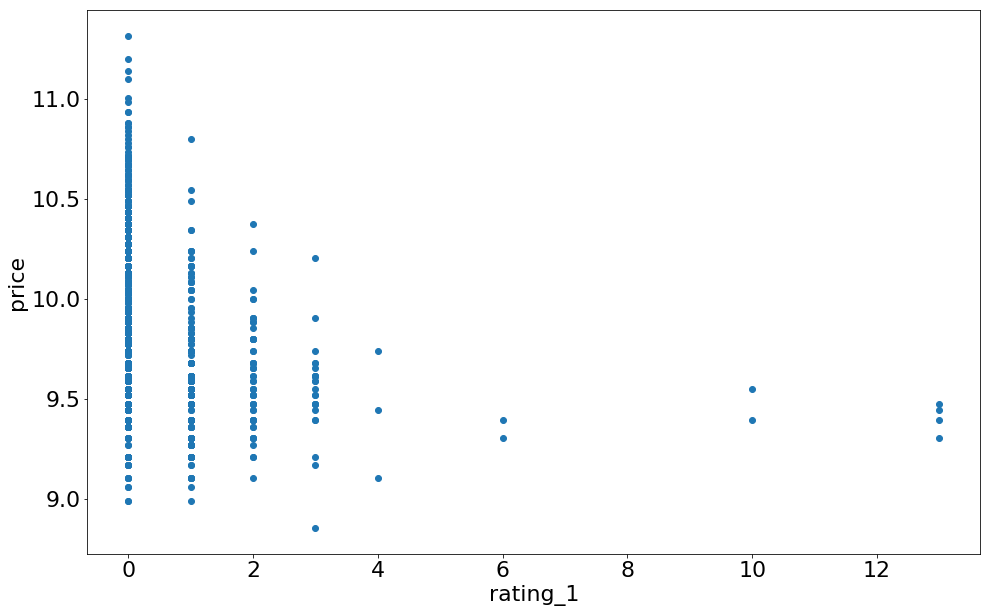

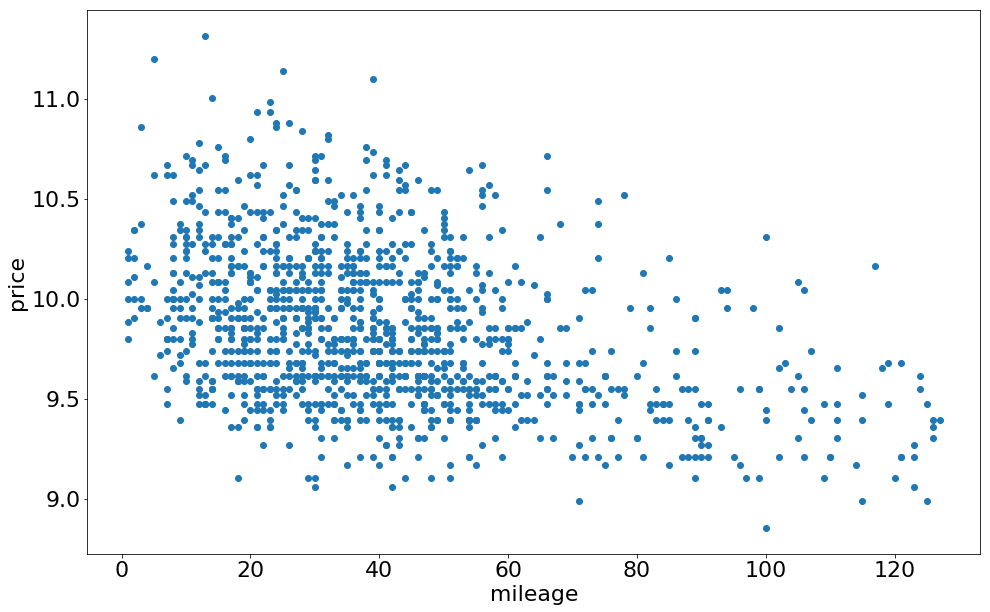

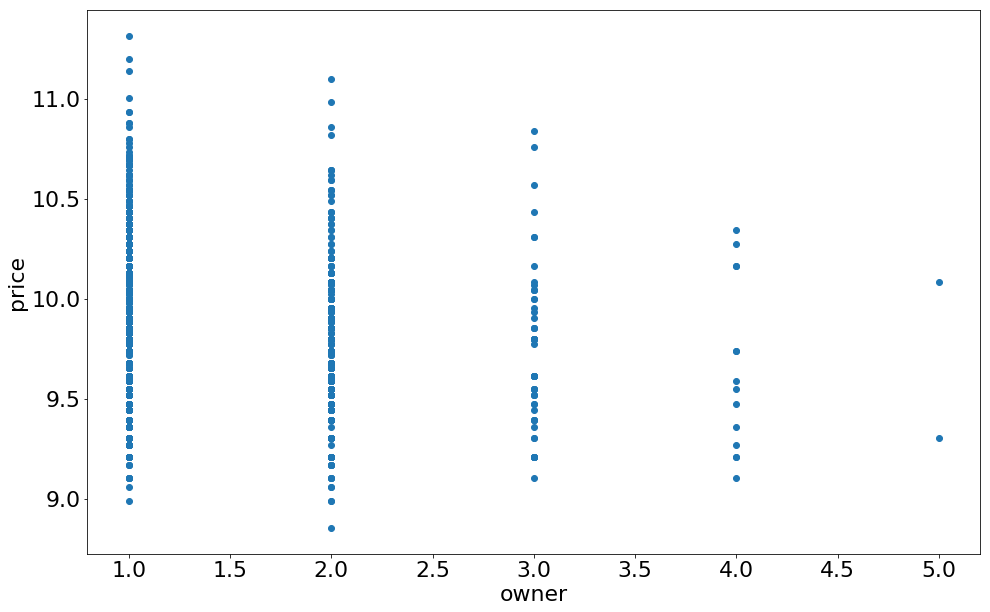

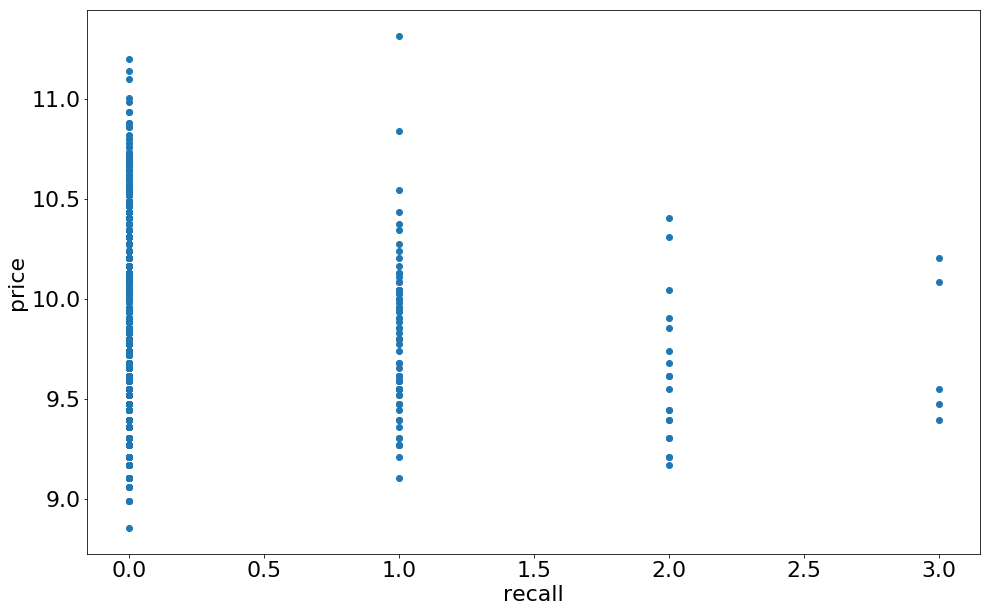

In [392]:
for col in df_num_train:
    plt.figure()
    ax = plt.scatter(x=df_num_train[col], y=y_train_log)
    plt.xlabel(col)
    plt.ylabel('price')

    image: quadratic/cubic
    age: quadratic/cubic
    city: quadratic/cubic
    highway: 
    exponential? logarithmic, polynomial?

In [941]:
# Create your model
model = sm.OLS(y_train, X_train_num)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     101.2
Date:                Sat, 14 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:44:49   Log-Likelihood:                -12908.
No. Observations:                1340   AIC:                         2.594e+04
Df Residuals:                    1280   BIC:                         2.625e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                        42.9083     20.396      2.104      0.036       2.895      82.921
age                        -1160.3147     81.553    -14.228      0.000   -1320.306   -1000.323
city                         256.2320     32.850      7.800      0.000     191.786     320.677
highway                     -338.2445     45.015     -7.514      0.000    -426.556    -249.933
transmission                 532.1978    482.146      1.104      0.270    -413.686    1478.082
drive                       2691.5255    332.003      8.107      0.000    2040.196    3342.855
engine                      1367.4769    274.319      4.985      0.000     829.312    1905.642
cylinder                    1138.6571    209.807      5.427      0.000     727.054    1550.261
horsepower                    -1.0924      3.755     -0.291      0.771      -8.459       6.275
torque                        28.8070      2.894      9.955      0.000      23.130      34.484
rating_5                       5.0567     14.333      0.353      0.724     -23.061      33.175
rating_4                      67.7926     37.577      1.804      0.071      -5.926     141.511
rating_3                      89.9724     94.475      0.952      0.341     -95.370     275.315
rating_2                    -342.8441    153.092     -2.239      0.025    -643.182     -42.506
rating_1                      15.2434    148.244      0.103      0.918    -275.584     306.071
mileage                      -84.0720      6.163    -13.642      0.000     -96.163     -71.981
owner                         53.5748    181.307      0.295      0.768    -302.117     409.267
event                          9.9047    656.128      0.015      0.988   -1277.300    1297.110
recall                      -473.7791    276.446     -1.714      0.087   -1016.117      68.559
store[T.Fremont, CA]        1533.4731    481.875      3.182      0.001     588.122    2478.824
store[T.Modesto, CA]         956.3294    488.605      1.957      0.051      -2.225    1914.884
store[T.Pleasanton, CA]      392.4823    459.174      0.855      0.393    -508.334    1293.299
store[T.Roseville, CA]       772.5560    464.980      1.661      0.097    -139.650    1684.762
store[T.Sacramento, CA]     1340.8645    489.807      2.738      0.006     379.953    2301.776
store[T.San Francisco, CA]   383.1518    458.896      0.835      0.404    -517.118    1283.422
store[T.San Jose, CA]        659.9718    478.343      1.380      0.168    -278.450    1598.394
store[T.Santa Rosa, CA]      -82.2692    463.609     -0.177      0.859    -991.786     827.248
Intercept                   1.687e+04   1640.905     10.280      0.000    1.36e+04    2.01e+04
make[T.Audi]                4126.9290   1218.864      3.386      0.001    1735.738    6518.120
make[T.BMW]                 2955.7443   104

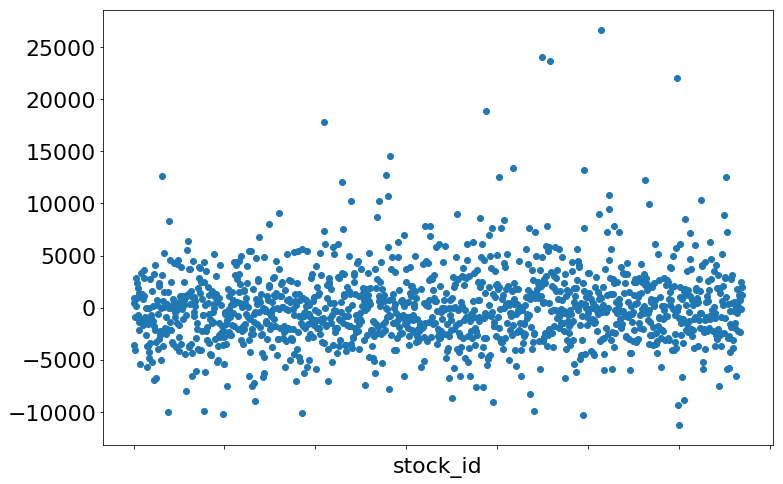

In [942]:
fit.resid.plot(style='o', figsize=(12,8));

In [943]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [944]:
# Create your model
model_log = sm.OLS(y_train_log, X_train_num)

# Fit your model to your training set
fit_log = model_log.fit()

# Print summary statistics of the model's performance
fit_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     137.4
Date:                Sat, 14 Jul 2018   Prob (F-statistic):               0.00
Time:                        16:46:17   Log-Likelihood:                 713.43
No. Observations:                1340   AIC:                            -1307.
Df Residuals:                    1280   BIC:                            -994.8
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
images                         0.0022      0.001      2.746      0.006       0.001       0.004
age                           -0.0556      0.003    -17.702      0.000      -0.062      -0.049
city                           0.0112      0.001      8.863      0.000       0.009       0.014
highway                       -0.0149      0.002     -8.588      0.000      -0.018      -0.011
transmission                  -0.0013      0.019     -0.069      0.945      -0.038       0.035
drive                          0.1246      0.013      9.748      0.000       0.099       0.150
engine                         0.0874      0.011      8.282      0.000       0.067       0.108
cylinder                       0.0210      0.008      2.595      0.010       0.005       0.037
horsepower                     0.0005      0.000      3.365      0.001       0.000       0.001
torque                         0.0007      0.000      6.488      0.000       0.001       0.001
rating_5                       0.0007      0.001      1.354      0.176      -0.000       0.002
rating_4                       0.0014      0.001      0.954      0.340      -0.001       0.004
rating_3                       0.0007      0.004      0.199      0.842      -0.006       0.008
rating_2                      -0.0156      0.006     -2.649      0.008      -0.027      -0.004
rating_1                      -0.0021      0.006     -0.359      0.719      -0.013       0.009
mileage                       -0.0041      0.000    -17.090      0.000      -0.005      -0.004
owner                         -0.0017      0.007     -0.249      0.803      -0.015       0.012
event                         -0.0037      0.025     -0.148      0.882      -0.053       0.046
recall                        -0.0091      0.011     -0.853      0.394      -0.030       0.012
store[T.Fremont, CA]           0.0608      0.019      3.277      0.001       0.024       0.097
store[T.Modesto, CA]           0.0246      0.019      1.310      0.190      -0.012       0.062
store[T.Pleasanton, CA]        0.0049      0.018      0.275      0.783      -0.030       0.040
store[T.Roseville, CA]         0.0167      0.018      0.936      0.350      -0.018       0.052
store[T.Sacramento, CA]        0.0387      0.019      2.053      0.040       0.002       0.076
store[T.San Francisco, CA]    -0.0042      0.018     -0.236      0.813      -0.039       0.030
store[T.San Jose, CA]          0.0137      0.018      0.743      0.458      -0.022       0.050
store[T.Santa Rosa, CA]       -0.0222      0.018     -1.244      0.214      -0.057       0.013
Intercept                      9.8516      0.063    155.993      0.000       9.728       9.975
make[T.Audi]                   0.1472      0.047      3.137      0.002       0.055       0.239
make[T.BMW]                    0.1440      

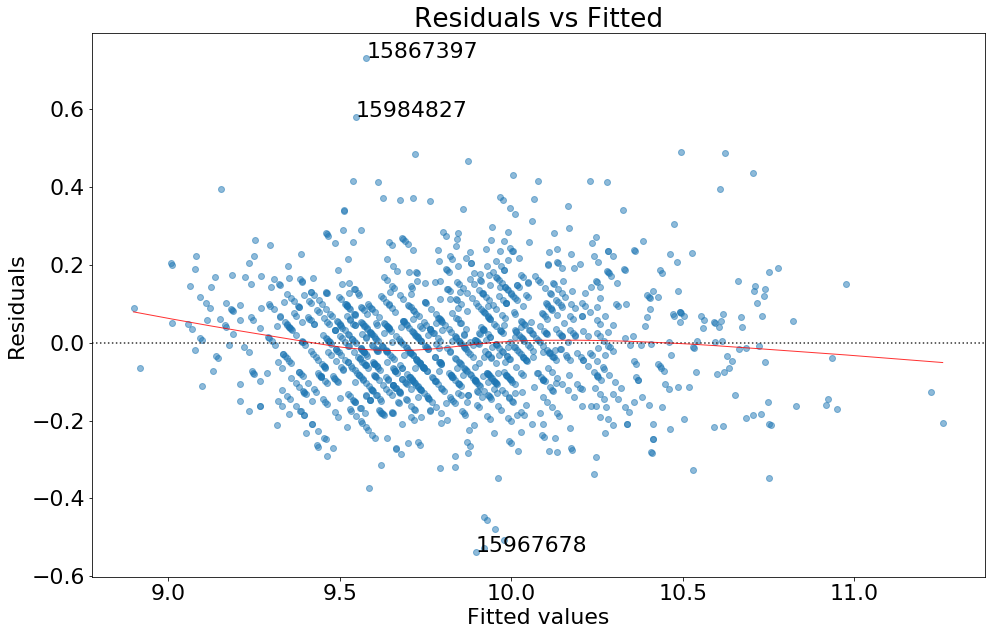

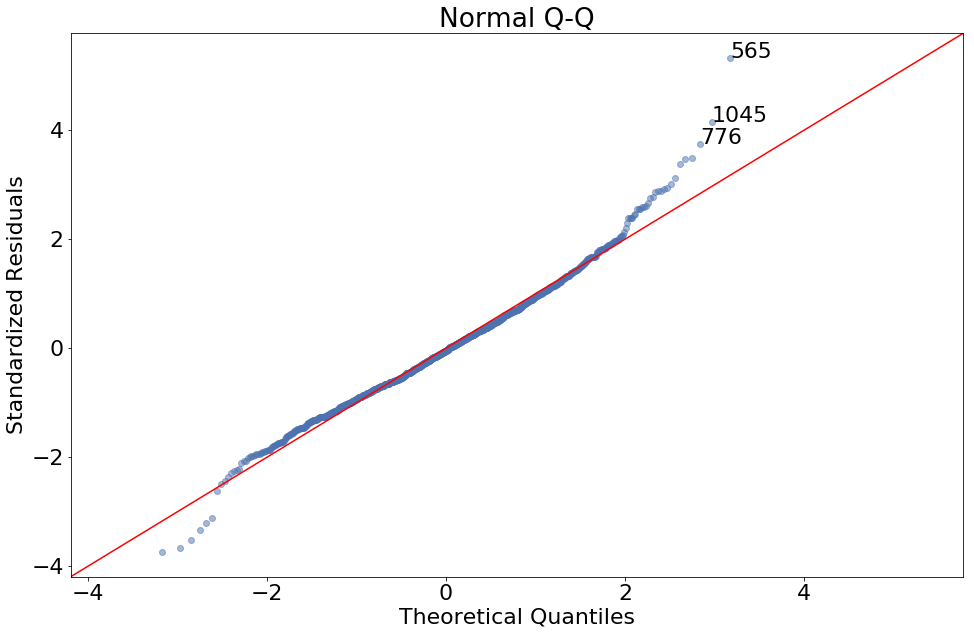

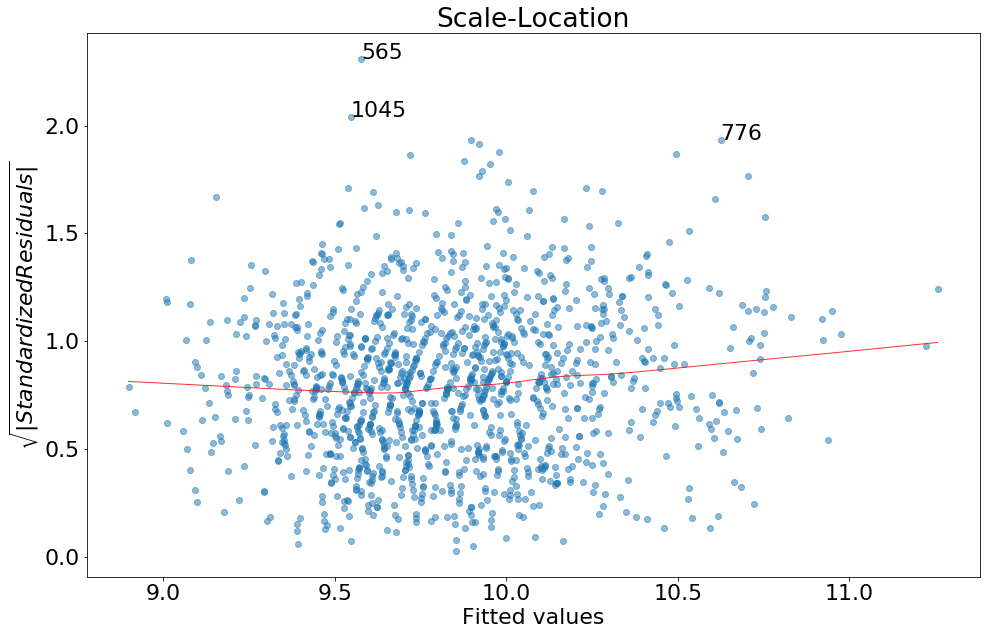

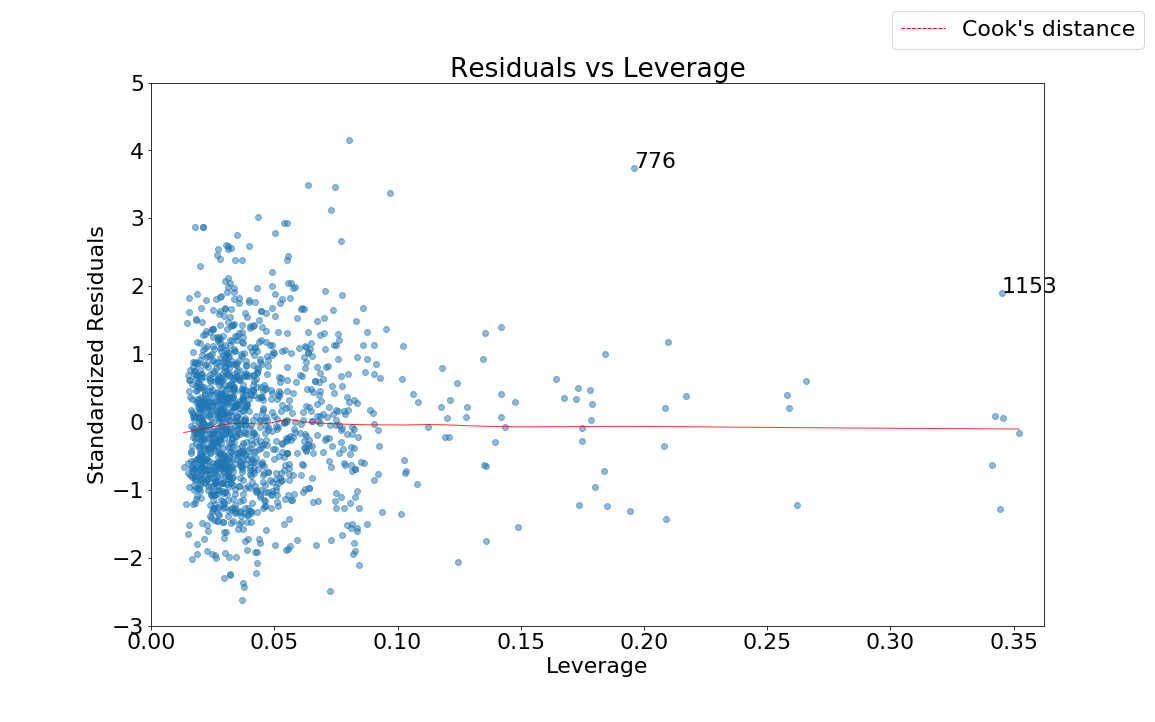

In [945]:
diagnostic_plots.diagnostic_plots(X_train_num, y_train_log, fit_log)

In [81]:
idx = '15990176'
row = df.index.get_loc(idx)

In [85]:
df.loc['15990176']

vin_id             3GTP2XE2XCG186089
images                            24
model             Sierra 1500 Denali
year                            2012
make                             GMC
city                              12
highway                           18
exterior_color                 Black
interior_color                 Black
transmission               Automatic
drive                            4WD
engine                           6.2
cylinder                           8
horsepower                       403
torque                           417
rating_5                          10
rating_4                           3
rating_3                           1
rating_2                           0
rating_1                           0
price                          33998
mileage                           43
store                   San Jose, CA
accident                           0
owner                              1
problem                           OK
odometer                          OK
e

In [82]:
row = X_train.index.get_loc(idx)

In [83]:
# Manually specify the value
row = 1153 

In [84]:
print ('Predicted:\t', np.exp(fit_log.predict(X_train)[row]))
print ('Actual:\t\t', y_train[row])
print (X_train.index[row])
print (X_train.iloc[row,:])

NameError: name 'fit_log' is not defined

In [448]:
y_train[y_train==81998]

725    81998.0
Name: price, dtype: float64

In [891]:
len(df.model.unique())

728

est = make_pipeline(PolynomialFeatures(degree), LinearRegression()) <br>
Fit our model to the training data <br>
est.fit(X, y)<br>
Plot the results<br>
plot_approximation(est, ax, label='degree=%d' % degree)

cars[o]=cars[o].replace('?',np.nan) <br>
cars=cars.dropna()

## Perform cross-validation

In [366]:
reg = LinearRegression()
scores = cross_val_score(reg, X_train_num, y_train_log, cv=5, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(np.exp(-np.mean(scores)))

1.04650172544


In [343]:
model = LinearRegression()
model.fit(X_train_num, y_train_log)
model.score(X_train_num, y_train_log)

0.70899328872590561

In [350]:
# Validate the model performance on test data
model.score(X_test_num,y_test_log)

0.74368383581648556

In [363]:
model.coef_

array([   0.002,   -0.028,    0.005,   -0.010,   -0.044,    0.061,
          0.001,    0.001,    0.000,   -0.004,    0.005,    0.001,
         -0.027,   -0.005,    0.008,    0.020])